In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime
import pandas as pd
import copy

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

In [4]:
import smart
import coronagraph as cg
from jakely.plot import ColorTable

Import local LUVOIR Habitable Exoplanet Characterization DRM code 

In [5]:
sys.path.insert(1, "../scripts")

import spectroscopy

Import coupled VPL Earth Model - Coronagraph code

In [7]:
sys.path.insert(1, "../../exomapping/notebooks")

import ForwardMethods
from ForwardMethods import EarthModel, DataGenerator, bandwidth
from TimeTurner import TimeTurner

Setup DRM

In [9]:
# Create LUVOIR DRM
drmx = spectroscopy.HEC_DRM(
            wantSNR = 8.5,       # SNR desired on Ahr_flat spectrum
            wantexp = 365.,      # Maximum program duration desired
            Ahr_flat = 0.20,     # Flat spectrum albedo to get wantSNR
            eta_int = 0.1,       # Interesting target fraction
            bandwidth = 0.2,     # Bandpass bandwidth 
            architecture = "A",  # LUVOIR architecture "A" or "B"
            telescope_mods = {}  # Telescope noise model keyword arguments
)

# Calculate table of exposure times
drmx.generate_exptime_table()

In [10]:
drmx.exptime_table.head(10)

,HIP,type,d [pc],UV 1,UV 2,UV 3,UV 4,UV 5,UV 6,vis 1,vis 2,vis 3,vis 4,NIR 1,NIR 2,NIR 3,NIR 4,Spec. Completeness
0,91772,K5,3.49174,4795.517824965829,75.73353763474026,6.3462790173350525,1.720068762812048,0.3819328392117149,0.5543561328159193,3.102920979635664,2.2914036519948295,2.8787579345547116,1.2889995547979307,0.9205597407736336,0.9315069755714868,1.2357242637754926,2.4024185417892148,1.0
1,8102,G8V,3.65017,nan,13.686116337416681,2.7254135148469625,1.1059591417647379,0.32824306743216625,0.5510146695788425,3.333782758654826,2.9813171027432204,4.318015826503313,2.1759176522792965,1.5301406018359995,1.725773609792996,2.5058206211671816,5.229663234076844,0.9782608695652174
2,85523,K5,4.5405,13307.690074663706,177.1110466235691,12.041609274395022,3.070540758432732,0.6672079929941587,0.9732329553664755,5.703126070002481,4.192129157201717,5.361640704165977,2.379442192394707,2.1813973334835133,2.269793862187854,3.13173114476341,6.43540063317844,1.0
3,99461,K2V,6.01504,5264.548226988776,124.59921859693902,12.736852605377115,4.00498060220363,1.0092487031848794,1.5966421392729795,10.148792548663488,8.295942165012518,11.740683448587141,5.512229556359268,6.5728940624166,7.47809522010468,11.23103183417392,25.032010105271706,1.0
4,12114,K3V,7.1803,19551.897543903164,331.00835816994066,24.228889972459097,6.649004894479273,1.5558278210305232,2.426393159887771,16.23737304168218,12.818969034145224,18.146065808883865,8.275970393974978,11.951161658936584,13.508864250800533,20.285919068098917,nan,0.8521739130434782
5,113283,K4Vp,7.60919,47381.83847109929,637.3368215649921,36.55267771766989,8.871874031425042,1.9321973925333003,2.94660978184302,19.988520633202633,15.16352315433122,21.029076459615702,9.354065925309811,14.003262263725892,15.506382638452564,22.91624983836494,nan,0.8521739130434782
6,32984,K3V,8.71004,41792.0222795433,654.9370293443433,41.58500324123637,10.728831622933507,2.4452999648469578,3.854985416322188,27.62170400847933,21.786697150131477,31.65547119684011,14.30960482739529,24.599162249639807,28.102203264411642,nan,nan,0.6956521739130435
7,57939,G8Vp,9.09174,3938.9349610565373,152.93253673714813,21.072668585978363,7.935092779114225,2.299750090916573,3.9757631815791203,28.37783744654804,25.95590866312797,41.535295894774144,20.550838223647226,35.43510005791853,44.247831758097554,72.35948814702235,174.1337413472838,1.0
8,61317,G0V,8.43953,418.08052088691386,53.34789261758467,13.781745083800958,6.9222948438121765,2.456616723162237,4.621099755692257,31.84046807374428,32.72254079467874,55.0586888882726,29.65745954296198,39.97463879643809,53.22270288236852,91.4886142875631,227.67908259419897,1.0
9,56997,G8Vvar,9.61169,4858.042325436398,181.58832505388867,24.20464642572932,9.036974072526847,2.611595750343327,4.530869475312212,32.92275584971977,30.17901159544433,48.733530604673476,24.074016431780365,43.6706550327392,54.71140646413482,89.77849193134827,nan,0.8521739130434782


In [11]:
# Define cases 
ibp = np.arange(len(drmx.bp_names))
case_names = [
    "All", 
    "-1 UV", 
    "-1 UV; -1 NIR", 
    "-2 UV; -1 NIR", 
    "Only vis",
    r"Only O$_2$ A-Band"
]
cases = [
    spectroscopy.get_iremove(drmx, Nremove_uv=0, Nremove_nir=0), 
    spectroscopy.get_iremove(drmx, Nremove_uv=1, Nremove_nir=0), 
    spectroscopy.get_iremove(drmx, Nremove_uv=1, Nremove_nir=1), 
    spectroscopy.get_iremove(drmx, Nremove_uv=2, Nremove_nir=1), 
    ibp[(drmx.bp_chan == 0) | (drmx.bp_chan == 2)],
    ibp[(drmx.bandpasses[:,0] > 0.76) | (drmx.bandpasses[:,1] < 0.76)]
]

# Define eta range
Xdraw = 500
etas = np.array([0.1, 0.2, 0.5, 1.0])
Ndraws = np.array(np.round(etas*drmx.NBIAS), dtype=int)

# Run DRM for Xdraw number of times
t_totx = np.zeros((len(Ndraws), len(cases), 3))
t_scix = np.zeros((len(Ndraws), len(cases), 3))
t_ovrx = np.zeros((len(Ndraws), len(cases), 3))
countx = np.zeros((len(Ndraws), len(cases), 3))
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        t_tmp = np.zeros(Xdraw)
        t_sci = np.zeros(Xdraw)
        t_ovr = np.zeros(Xdraw)
        c_tmp = np.zeros(Xdraw)
        for x in range(Xdraw):
            t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = drmx.run_hec_drm(Ndraw = Ndraws[i], 
                                                                                                           verbose = False, 
                                                                                                           iremove = cases[j], 
                                                                                                           wantexp_days=drmx.wantexp)
            t_tmp[x] = np.sum(t_tot_sort[:count_in_texp]) / 24.
            t_sci[x] = np.sum(t_sci_sort[:count_in_texp]) / 24.
            t_ovr[x] = np.sum(t_ovr_sort[:count_in_texp]) / 24.
            c_tmp[x] = count_in_texp
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_tmp)
        t_totx[i,j,0], t_totx[i,j,1], t_totx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_sci)
        t_scix[i,j,0], t_scix[i,j,1], t_scix[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_ovr)
        t_ovrx[i,j,0], t_ovrx[i,j,1], t_ovrx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_tmp)
        countx[i,j,0], countx[i,j,1], countx[i,j,2] = q_50, q_p, q_m

Text(0,1,'Total Exposure Time (days)')

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


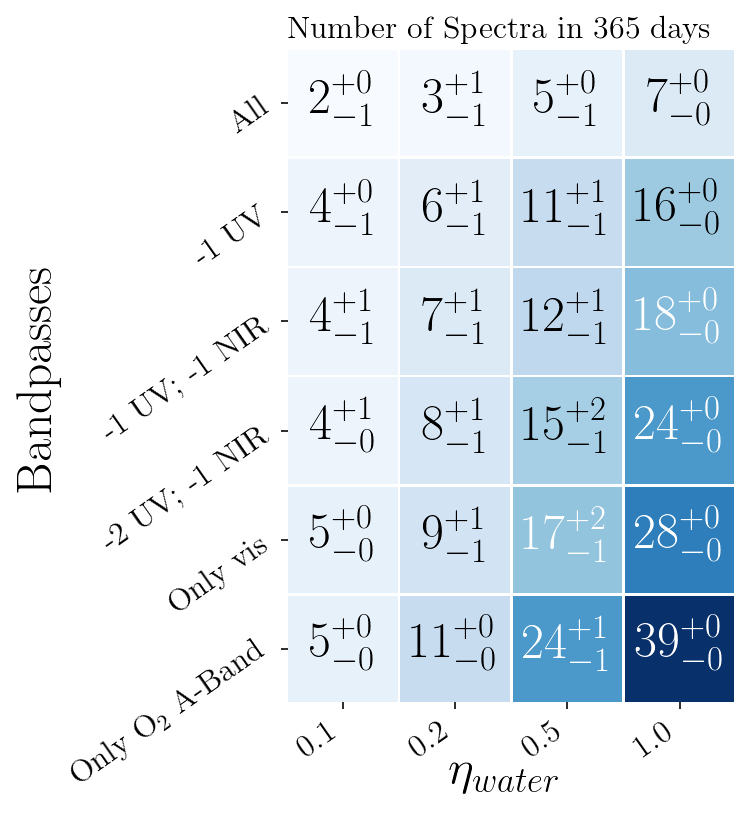

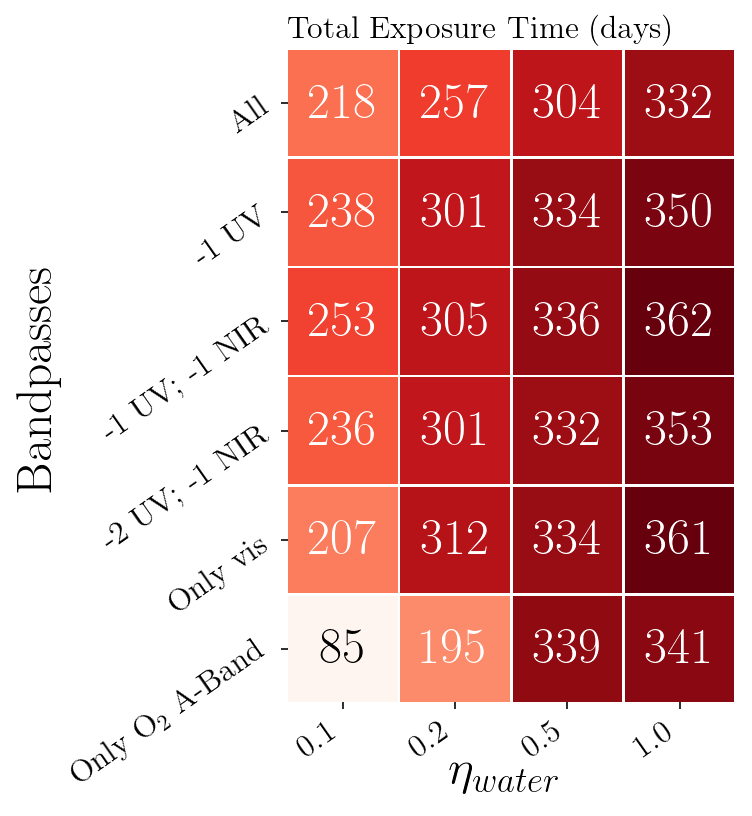

In [12]:
# Make Table of results
fig, ax = ColorTable(etas, case_names, countx[:,:,0], fmt = "%i", data_pm = (countx[:,:,1], countx[:,:,2]), labelfontsize=16, labelrotation=35, 
                     ylabel = "Bandpasses", xlabel = r"$\eta_{water}$", ylabel_spacing=-0.35, xlabel_spacing = 0.01)
ax[0,0].set_title("Number of Spectra in %i days" %drmx.wantexp, ha = "left", fontsize = 16, loc = "left")

fig, ax = ColorTable(etas, case_names, t_totx[:,:,0], fmt = "%i", labelfontsize=16, labelrotation=35, colormap = "Reds",
                     ylabel = "Bandpasses", xlabel = r"$\eta_{water}$", ylabel_spacing=-0.35, xlabel_spacing = 0.01, textsize = 16)
                     #data_pm = (t_totx[:,:,1], t_totx[:,:,2]))
ax[0,0].set_title("Total Exposure Time (days)", ha = "left", fontsize = 16, loc = "left")

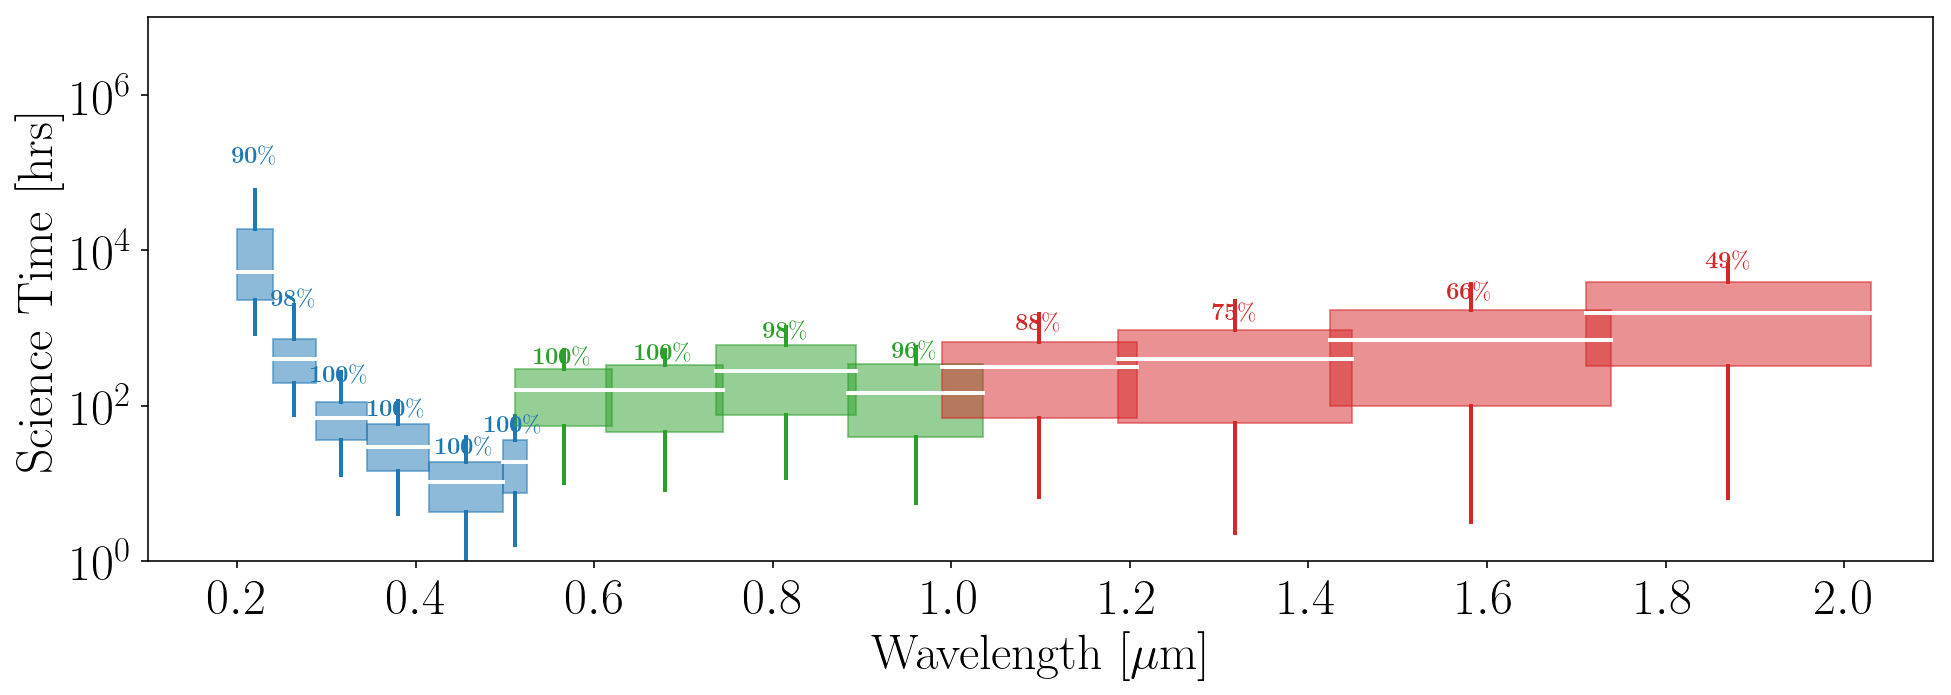

In [13]:
fig = drmx.plot_bp_exptimes(plot_spectrum=False)

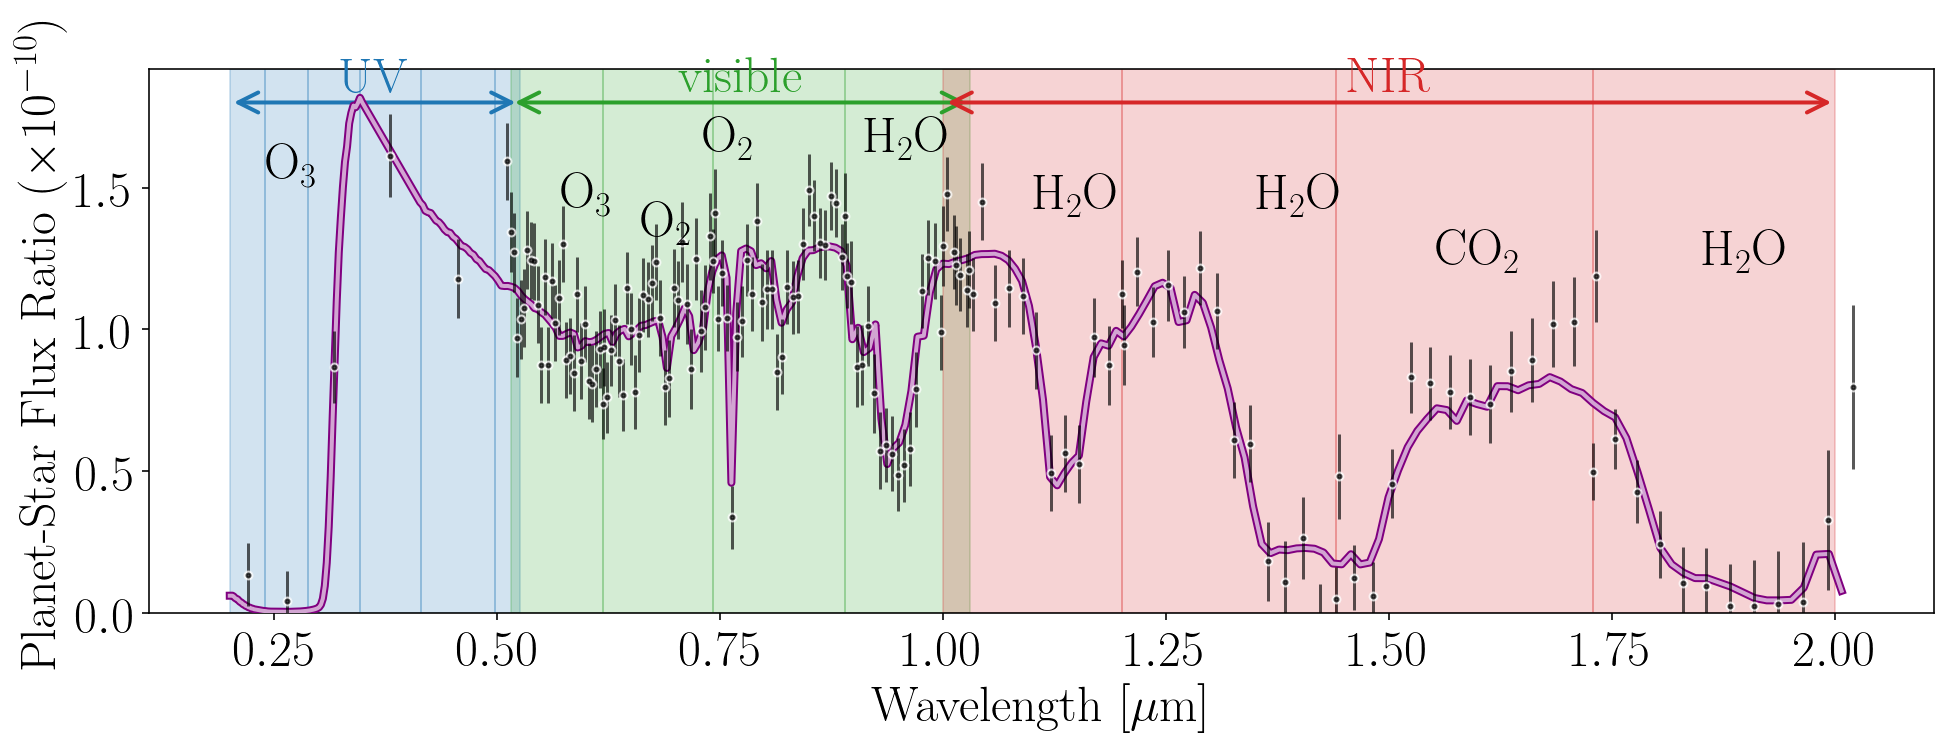

In [14]:
fig, ax = drmx.plot_observed_spectrum()

In [15]:
# Randomly draw stellar sample indices
idraw = np.random.choice(np.arange(drmx.NBIAS), size=1, replace=False)[0]

# Get exptimes
texpbp = drmx.tpbpcs_rect[idraw,:]

# Set system parameters for this star
drmx.prep_ith_star(idraw)

In [16]:
for ibp in range(len(drmx.bandpasses)):
    print(ibp, drmx.bp_names[ibp], drmx.bp_chan[ibp], drmx.bandpasses[ibp])

(0, u'UV 1', 0, array([0.2 , 0.24]))
(1, u'UV 2', 0, array([0.24 , 0.288]))
(2, u'UV 3', 0, array([0.288 , 0.3456]))
(3, u'UV 4', 0, array([0.3456 , 0.41472]))
(4, u'UV 5', 0, array([0.41472 , 0.497664]))
(5, u'UV 6', 0, array([0.497664, 0.525   ]))
(6, u'vis 1', 1, array([0.515, 0.618]))
(7, u'vis 2', 1, array([0.618 , 0.7416]))
(8, u'vis 3', 1, array([0.7416 , 0.88992]))
(9, u'vis 4', 1, array([0.88992, 1.03   ]))
(10, u'NIR 1', 2, array([1. , 1.2]))
(11, u'NIR 2', 2, array([1.2 , 1.44]))
(12, u'NIR 3', 2, array([1.44 , 1.728]))
(13, u'NIR 4', 2, array([1.728, 2.   ]))


In [17]:
j = 3
case = cases[j]
print(case_names[j])

t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = drmx.run_hec_drm(Ndraw = 20, 
                                                                                               verbose = True, 
                                                                                               iremove = case, 
                                                                                               wantexp_days=drmx.wantexp)

-2 UV; -1 NIR
HIP69972 - K3V - 11.82pc
    - 40.9% Complete Spectrum : 10.09 days
    - UV Spectrum : 5.98 days
    - Optical Spectrum : 10.09 days
    - NIR Spectrum : 0.00 days
    - Overhead 1.25 days
HIP76829 - F5IV-V - 17.44pc
    - 80.4% Complete Spectrum : 254.65 days
    - UV Spectrum : 34.26 days
    - Optical Spectrum : 234.39 days
    - NIR Spectrum : 220.39 days
    - Overhead 25.78 days
HIP99461 - K2V - 6.02pc
    - 80.4% Complete Spectrum : 1.86 days
    - UV Spectrum : 0.81 days
    - Optical Spectrum : 1.49 days
    - NIR Spectrum : 1.05 days
    - Overhead 0.50 days
HIP22263 - G3V - 13.28pc
    - 80.4% Complete Spectrum : 35.85 days
    - UV Spectrum : 3.04 days
    - Optical Spectrum : 17.06 days
    - NIR Spectrum : 35.85 days
    - Overhead 3.90 days
HIP80337 - G3/G5V - 12.78pc
    - 64.8% Complete Spectrum : 16.75 days
    - UV Spectrum : 2.84 days
    - Optical Spectrum : 13.92 days
    - NIR Spectrum : 14.23 days
    - Overhead 1.97 days
HIP113283 - K4Vp - 7.61pc

In [18]:
ibp = 8

itarget = 3
drmx.tpbpcs_rect[idraw, ibp]
N =  int(np.ceil(tpbpcs_draws[itarget,ibp])) 
tpbpcs_draws[itarget,ibp], int(np.ceil(tpbpcs_draws[itarget,ibp]))

(69.88648428003314, 70)

In [19]:
which_earth = "True_Earth"
which_phase = 90.

ibp = 8
channel = spectroscopy.CHANNELS[drmx.bp_chan[ibp]]
telescope = spectroscopy.default_luvoir(architecture=drmx.architecture, channel=channel)
telescope.lammin = drmx.bandpasses[ibp][0]
telescope.lammax = drmx.bandpasses[ibp][1]

# Starting index
istart = 0
# Set number of consecutive exposures
#N = 100
# Set the integration time per exposure
iN = 1
# Set number of neighboring pixels to coadd (int or "all")
iM = "all"

# Instantiate DataGenerator object with EarthModel data
data = DataGenerator(earth_model = EarthModel())

# Select the Earth Model dataset with HDF5 file
data.select_dataset(which_earth = which_earth, which_phase = which_phase)

# Set default telescope, planet and star
#data.set_default_observing_system()
data.telescope = telescope
data.planet = drmx.cn.planet
data.star = drmx.cn.star

# Create default dataset
data.create_mock_dataset(istart = istart, N = N, iN = iN, iM = iM, 
                         imod = data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"].shape[0])

HDF5 file opened


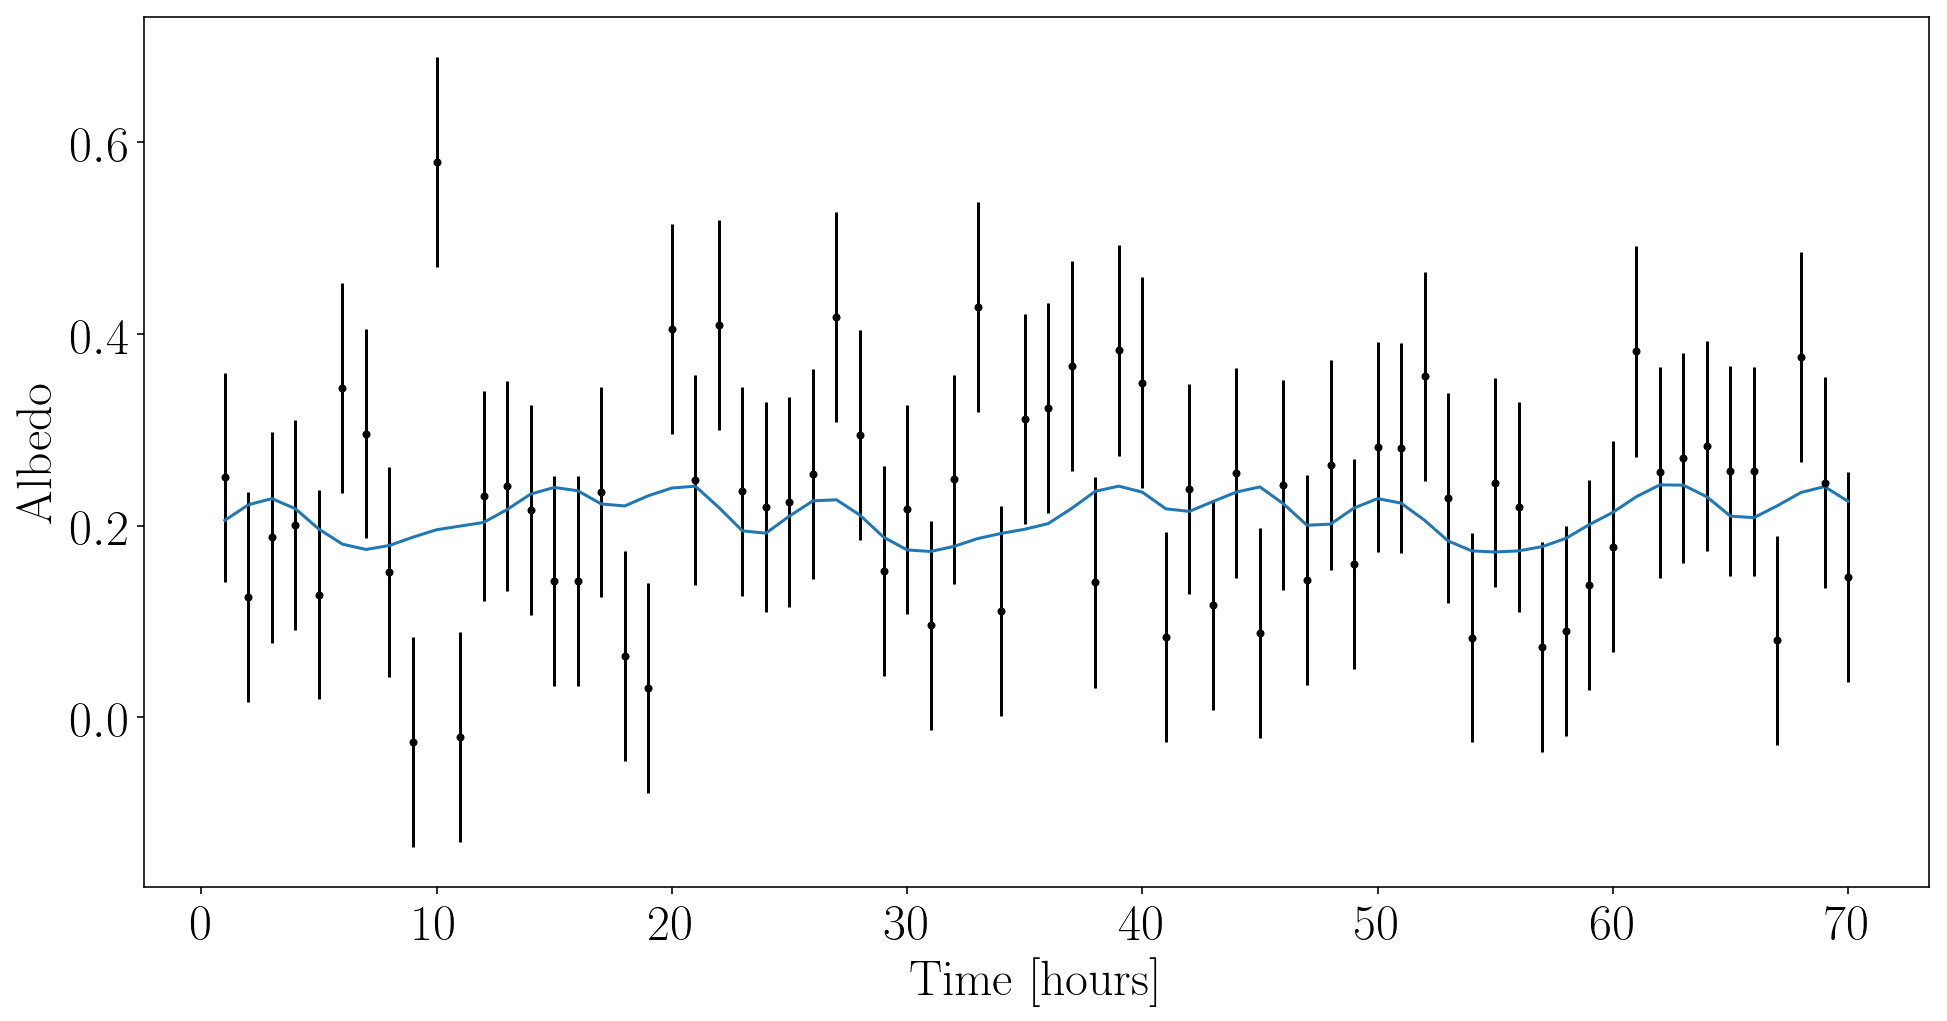

In [20]:
x = data.times
y = data.obs[:,0]
yt = data.A[:,0]
yerr = data.sig[:,0]

fig, ax = plt.subplots(figsize = (16,8))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Albedo")
ax.errorbar(x, y, yerr=yerr, fmt=".", color = "k")
ax.plot(x, yt, color = "C0")

In [21]:
drmx.tpbpcs_rect[:,7]

array([  44.01098736,    2.9813171 ,   74.89766527,   12.81896903,
         56.3734147 ,  138.69532828,   32.72254079,   32.76976259,
        299.64269342,   21.78669715,  182.1406306 , 1224.66238354,
         91.52403254,   25.95590866,    8.29594217,  145.33145994,
         44.91411996,    2.29140365,  173.15097507,   15.16352315,
        197.43967598,   64.70517276,    4.19212916,   87.02632464,
        159.94425892,   30.1790116 ,   45.32463121,  198.30117969,
         54.28969735,  334.47691912,  171.20617427,  334.13295096,
        519.20445784,  382.13330802,   74.12667428,  490.53654511,
        459.63968465,  525.09760971,   71.5257854 ,  128.67669962,
        761.05642597,  237.26280661,  609.6322753 ,  475.6479011 ,
        382.52112042,  219.14339299,  195.17405224,  127.37996579,
        376.64253615,  194.35396792,  447.46338707,  276.99666418,
        400.29188508])

In [22]:
itarget = 4
tpbpcs_draws[itarget,:], np.ceil(tpbpcs_draws[itarget,:])

(array([1.85830258e+04, 4.74917272e+02, 4.52988999e+01, 1.46485483e+01,
        3.88799052e+00, 6.62742405e+00, 5.10472639e+01, 4.49141200e+01,
        7.21611593e+01, 3.44554647e+01, 7.09939349e+01, 8.71183307e+01,
                   nan,            nan]),
 array([1.8584e+04, 4.7500e+02, 4.6000e+01, 1.5000e+01, 4.0000e+00,
        7.0000e+00, 5.2000e+01, 4.5000e+01, 7.3000e+01, 3.5000e+01,
        7.1000e+01, 8.8000e+01,        nan,        nan]))

In [36]:
# Randomly draw stellar sample indices
idraw = np.random.choice(np.arange(drmx.NBIAS), size=1, replace=False)[0]

# Get exptimes
texpbp = drmx.tpbpcs_rect[idraw,:]

# Set system parameters for this star
drmx.prep_ith_star(idraw)

# 
icase = 4
case = cases[icase]

print(drmx.cn.planet)
print(drmx.cn.star)
print(case_names[icase], case)

for i in range(len(drmx.bp_names)):
    print("%s : %.0f hours" %(drmx.bp_names[i], np.ceil(texpbp[i])))

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 12.4938
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 0.7576617601771974
- Phase angle (deg) : 90.00000250447816
- Lambertian phase function : 0.318309864328096
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0
Star: 
-----
- Effective Temperature (K) : 4900.0
- Radius (Solar Radii) : 1.05
('Only vis', array([ 0,  1,  2,  3,  4,  5, 10, 11, 12, 13]))
UV 1 : 29926 hours
UV 2 : 727 hours
UV 3 : 64 hours
UV 4 : 21 hours
UV 5 : 6 hours
UV 6 : 10 hours
vis 1 : 74 hours
vis 2 : 65 hours
vis 3 : 107 hours
vis 4 : 51 hours
NIR 1 : 114 hours
NIR 2 : nan hours
NIR 3 : nan hours
NIR 4 : nan hours


HDF5 file opened
HDF5 file opened
HDF5 file opened
HDF5 file opened


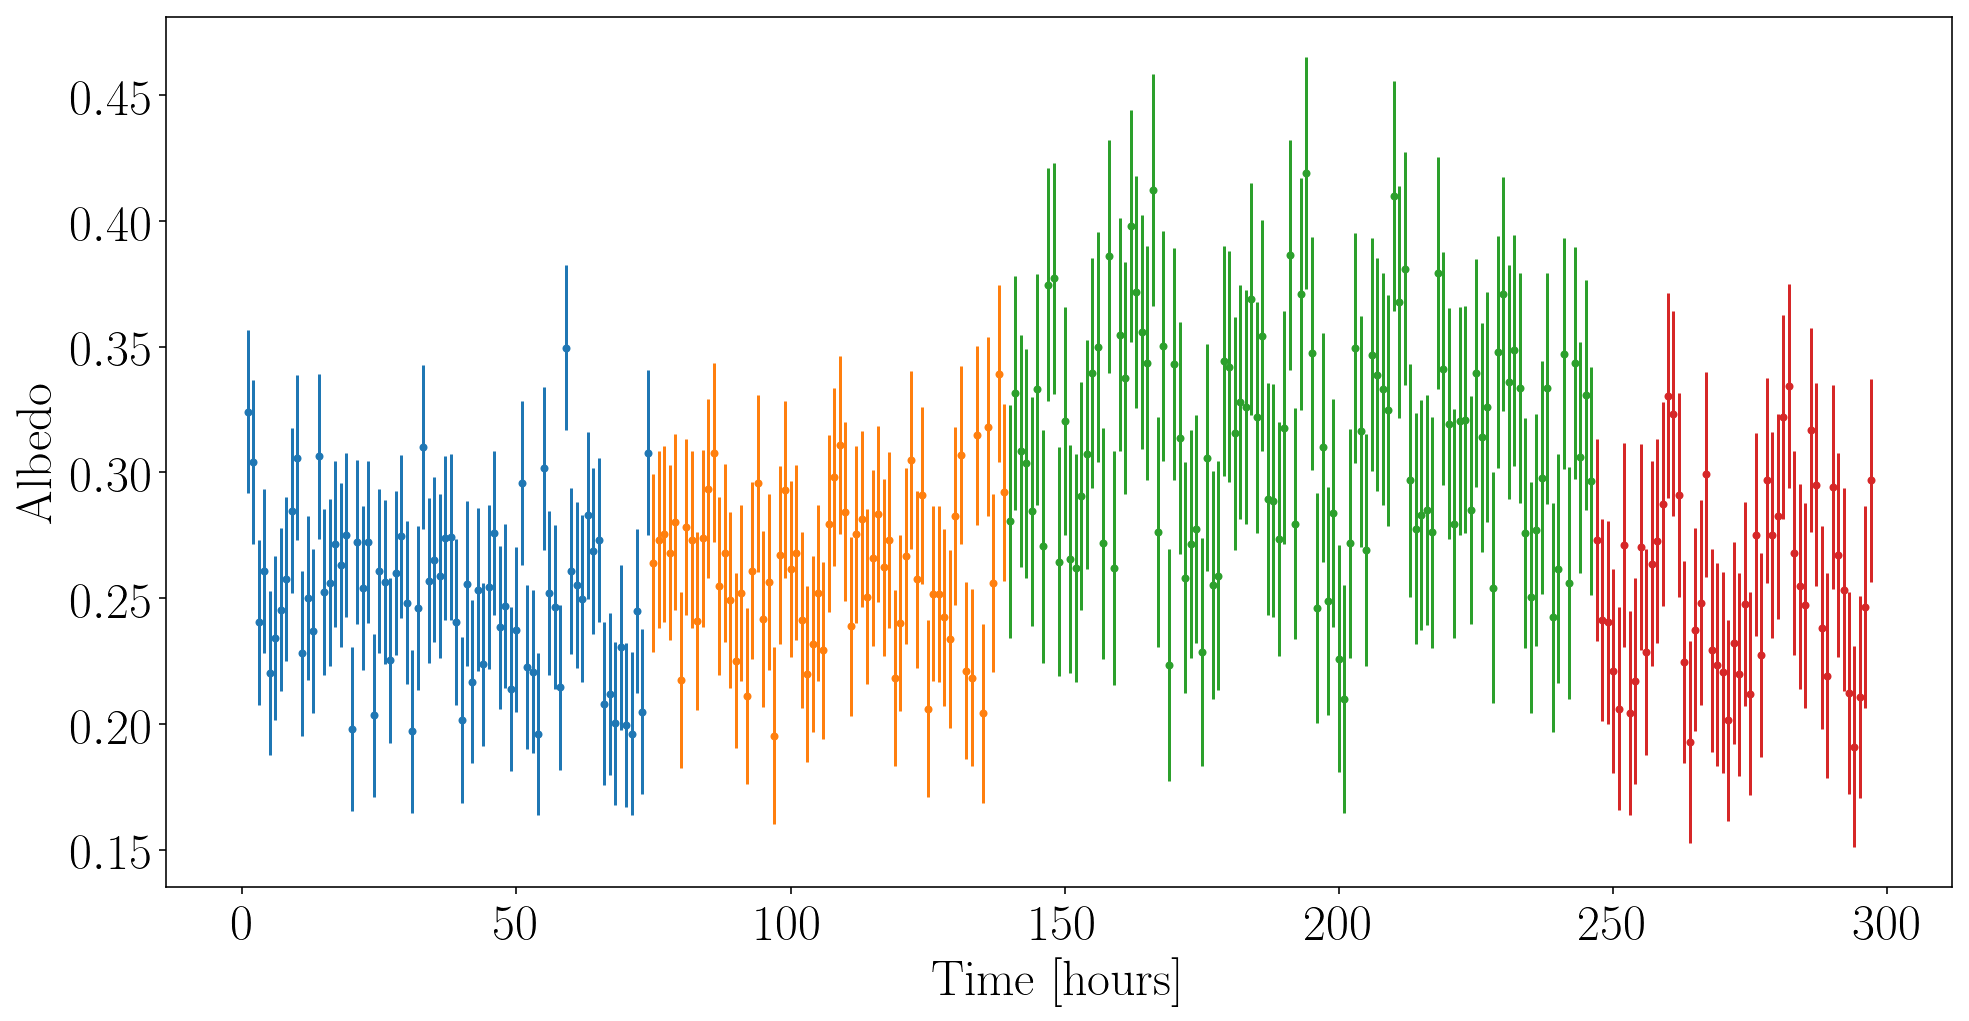

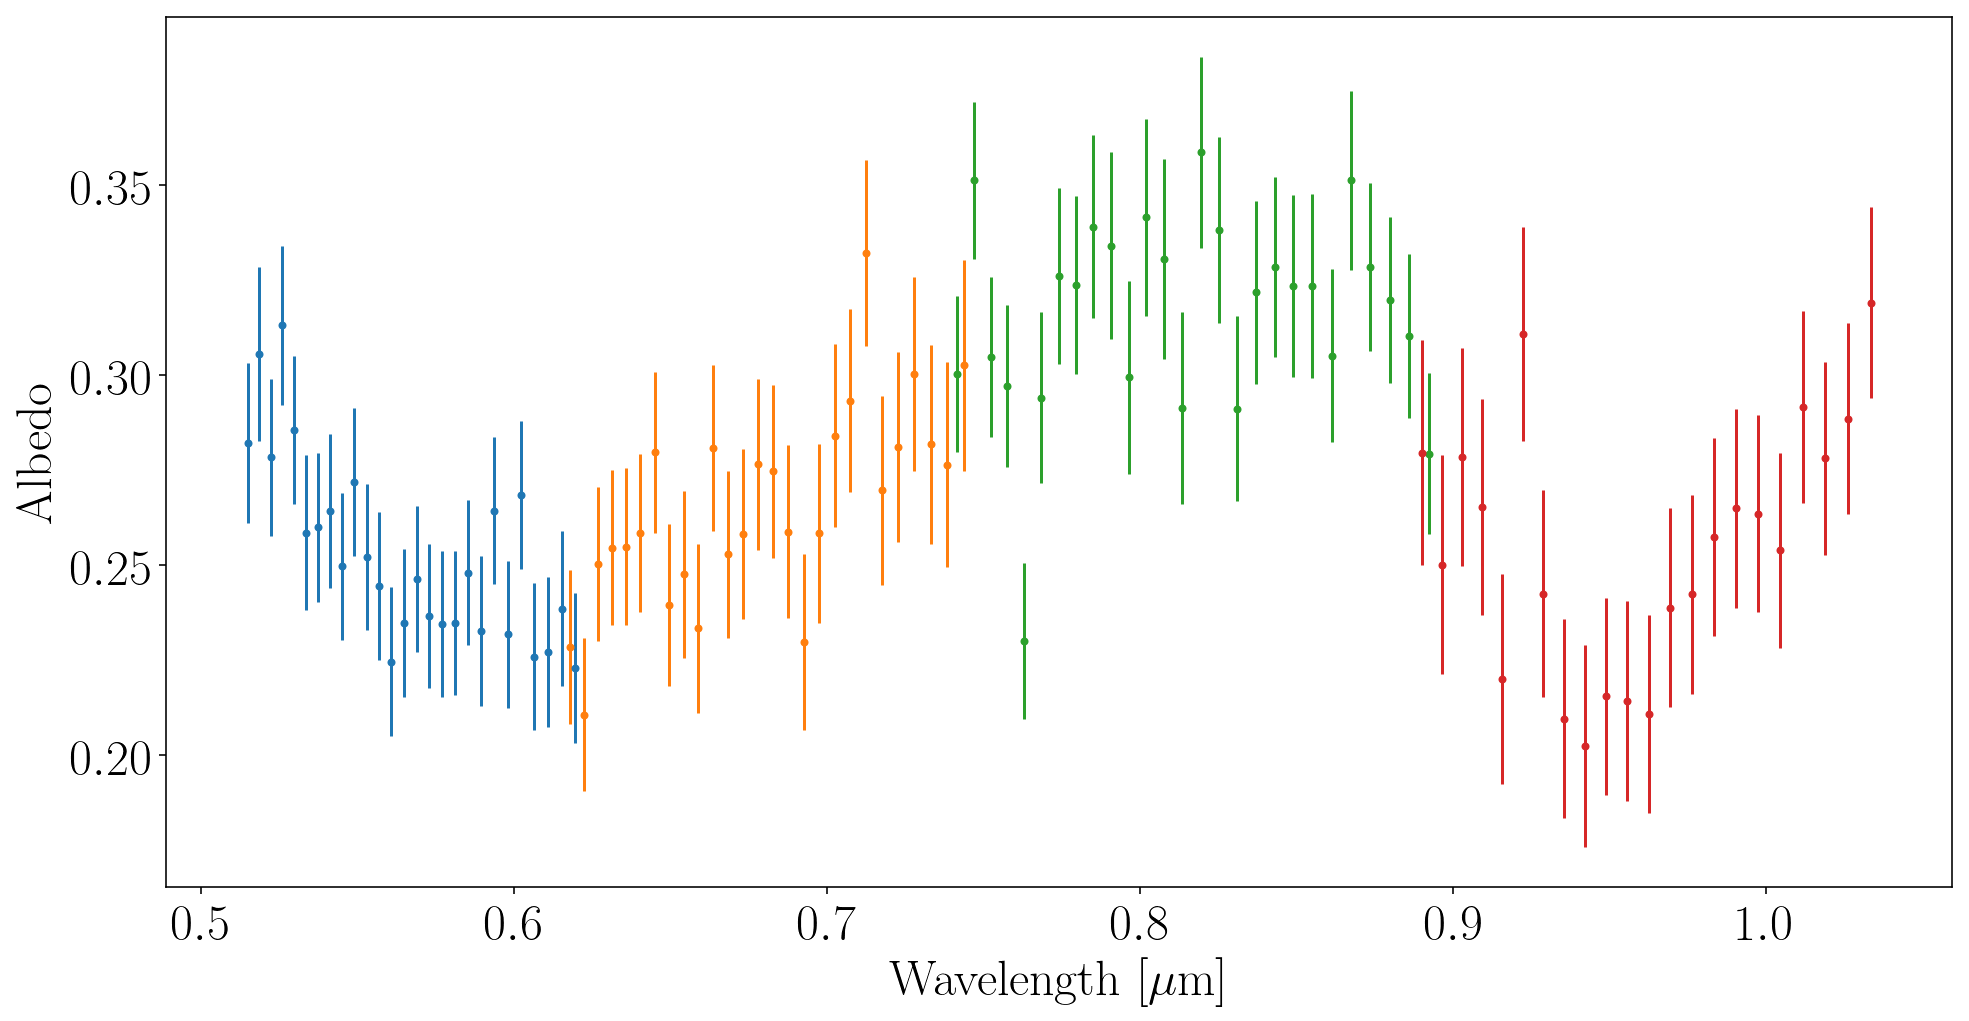

In [46]:
fig, ax = plt.subplots(figsize = (16,8))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Albedo")

fig2, ax2 = plt.subplots(figsize = (16,8))
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel("Albedo")

# Starting index
istart = 0

ts = []
ys = []
dys = []
bps = []

lams = []
Aobs = []
Asigs = []
Atrus = []
SNRs = []

for ibp in range(len(drmx.bandpasses)):
    
    if np.isfinite(texpbp[ibp]):
        Ntexp = int(np.ceil(texpbp[ibp]))
    else:
        Ntexp = np.nan
    
    if (ibp not in case) and (np.isfinite(Ntexp)):

        which_earth = "True_Earth"
        which_phase = 90.

        channel = spectroscopy.CHANNELS[drmx.bp_chan[ibp]]
        telescope = spectroscopy.default_luvoir(architecture=drmx.architecture, channel=channel)
        telescope.lammin = drmx.bandpasses[ibp][0]
        telescope.lammax = drmx.bandpasses[ibp][1]


        # Set number of consecutive exposures
        #N = 100
        N =  Ntexp

        # Set the integration time per exposure
        iN = 1

        # Set number of neighboring pixels to coadd (int or "all")
        iM = "all"

        # Instantiate DataGenerator object with EarthModel data
        data = DataGenerator(earth_model = EarthModel())

        # Select the Earth Model dataset with HDF5 file
        data.select_dataset(which_earth = which_earth, which_phase = which_phase)

        # Set default telescope, planet and star
        #data.set_default_observing_system()
        data.telescope = telescope
        data.planet = drmx.cn.planet
        data.star = drmx.cn.star
        
        if False:
            
            # Create timeseries dataset
            data.create_mock_dataset(istart = istart, N = N, iN = iN, iM = iM, 
                                     imod = data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"].shape[0])

            x = data.times + istart
            y = data.obs[:,0]
            yerr = data.sig[:,0]
            
            ts.append(x)
            ys.append(y)
            dys.append(yerr)
            bps.append([drmx.bp_names[ibp] for _ in x] )

            # Create spectrum dataset
            data2 = copy.copy(data)
            data2.create_mock_dataset(istart = istart, N = N, iN = iN, iM = 1, 
                                      imod = data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"].shape[0])

            # Use Modify exposure to temporally coadd entire dataset at the spectrograph's native resolution
            times_new, A_new, obs_new, sig_new, SNR_new = ForwardMethods.modify_exposure(data2.A, data2.SNR, window = data2.N,
                                                         og_texp = 1.,
                                                         snr_method = "coadd",
                                                         verbose = False, time_ref = "right")
            
            lams.append(data2.lam[0,:])
            Aobs.append(obs_new[0,:])
            Asigs.append(sig_new[0,:])
            Atrus.append(A_new[0,:])
            SNRs.append(SNR_new[0,:])

        else:
            
            bps.append([drmx.bp_names[ibp] for _ in range(N)] )
            
            x, y, yerr = [], [], []
            t2, x2, y2, yerr2 = [], [], [], []
            
            # Loop over time increments (hours)
            for i in range(N):
        
                # Create timeseries dataset
                data.create_mock_dataset(istart = istart+i, N = 1, iN = 1, iM = 1, 
                                         imod = data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"].shape[0])
                
                
                t0 = data.times + istart + i
                x0 = data.lam[0,:]
                y0 = data.obs[0,:]
                yerr0 = data.sig[0,:]
                
                t2.append(t0)
                x2.append(x0)
                y2.append(y0)
                yerr2.append(yerr0)
                
                # Coadd spectral pixels into lightcurve
                lamlr = np.array([0.5*(telescope.lammin - telescope.lammin/telescope.resolution + telescope.lammax + telescope.lammax/telescope.resolution)])
                dlamlr = np.array([(telescope.lammax + telescope.lammax/telescope.resolution) - (telescope.lammin - telescope.lammin/telescope.resolution)])
                specLR, errLR = cg.downbin_spec_err(y0, yerr0, x0, lamlr, dlam = dlamlr)
        
                x.append(t0)
                y.append(specLR)
                yerr.append(errLR)
                
            #xs, ys, dys = np.hstack(x), np.hstack(y), np.hstack(yerr)
            ts.append(np.hstack(x))
            ys.append(np.hstack(y))
            dys.append(np.hstack(yerr))
            
            t2, x2, y2, yerr2 = np.hstack(t2), np.array(x2), np.array(y2), np.array(yerr2)
            tlr = np.array([0.5*(t2[-1] + t2[0])])
            dtlr = np.array([(t2[-1] - t2[0])])
            
            tmpy = []
            tmpyerr = []
            # Loop over spectral elements
            for i in range(len(x2[0])):
                
                # Coadd in time for deep spectra
                specLR, errLR = cg.downbin_spec_err(y2[:,i], yerr2[:,i], t2, tlr, dlam = dtlr)
                tmpy.append(specLR)
                tmpyerr.append(errLR)
                
            lams.append(x2[0])
            Aobs.append(np.array(tmpy))
            Asigs.append(np.array(tmpyerr))

        ax.errorbar(x, y, yerr=yerr, fmt=".")
        
        ax2.errorbar(lams[-1], Aobs[-1], yerr=Asigs[-1], fmt = ".")
        
        istart += N

In [38]:
import gatspy 

In [47]:
# Using the LombScargleMultiband
lsmodel = gatspy.periodic.LombScargleMultiband(fit_period=True)

In [48]:
# Specify valid period range to search
lsmodel.optimizer.period_range=(1.2, 50.0)

```python
# Example code for data shape
rrlyrae = gatspy.datasets.fetch_rrlyrae()
t, mag, dmag, filts = rrlyrae.get_lightcurve(rrlyrae.ids[0])
```

In [49]:
# Coerce "data" into LombScargleMultiband format
t = np.hstack(ts)
y = np.hstack(ys)
dy = np.hstack(dys)
filts = np.hstack(bps)

In [50]:
# Fit periodogram
lsmodel.fit(t, y, dy, filts)

# Get best period
best_period = lsmodel.best_period
best_period

Finding optimal frequency:
 - Estimated peak width = 0.0212
 - Using 5 steps per peak; omega_step = 0.00425
 - User-specified period range:  1.2 to 50
 - Computing periods at 1205 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


21.764705882352946

Text(0.1,0.5,'Relative Albedo')

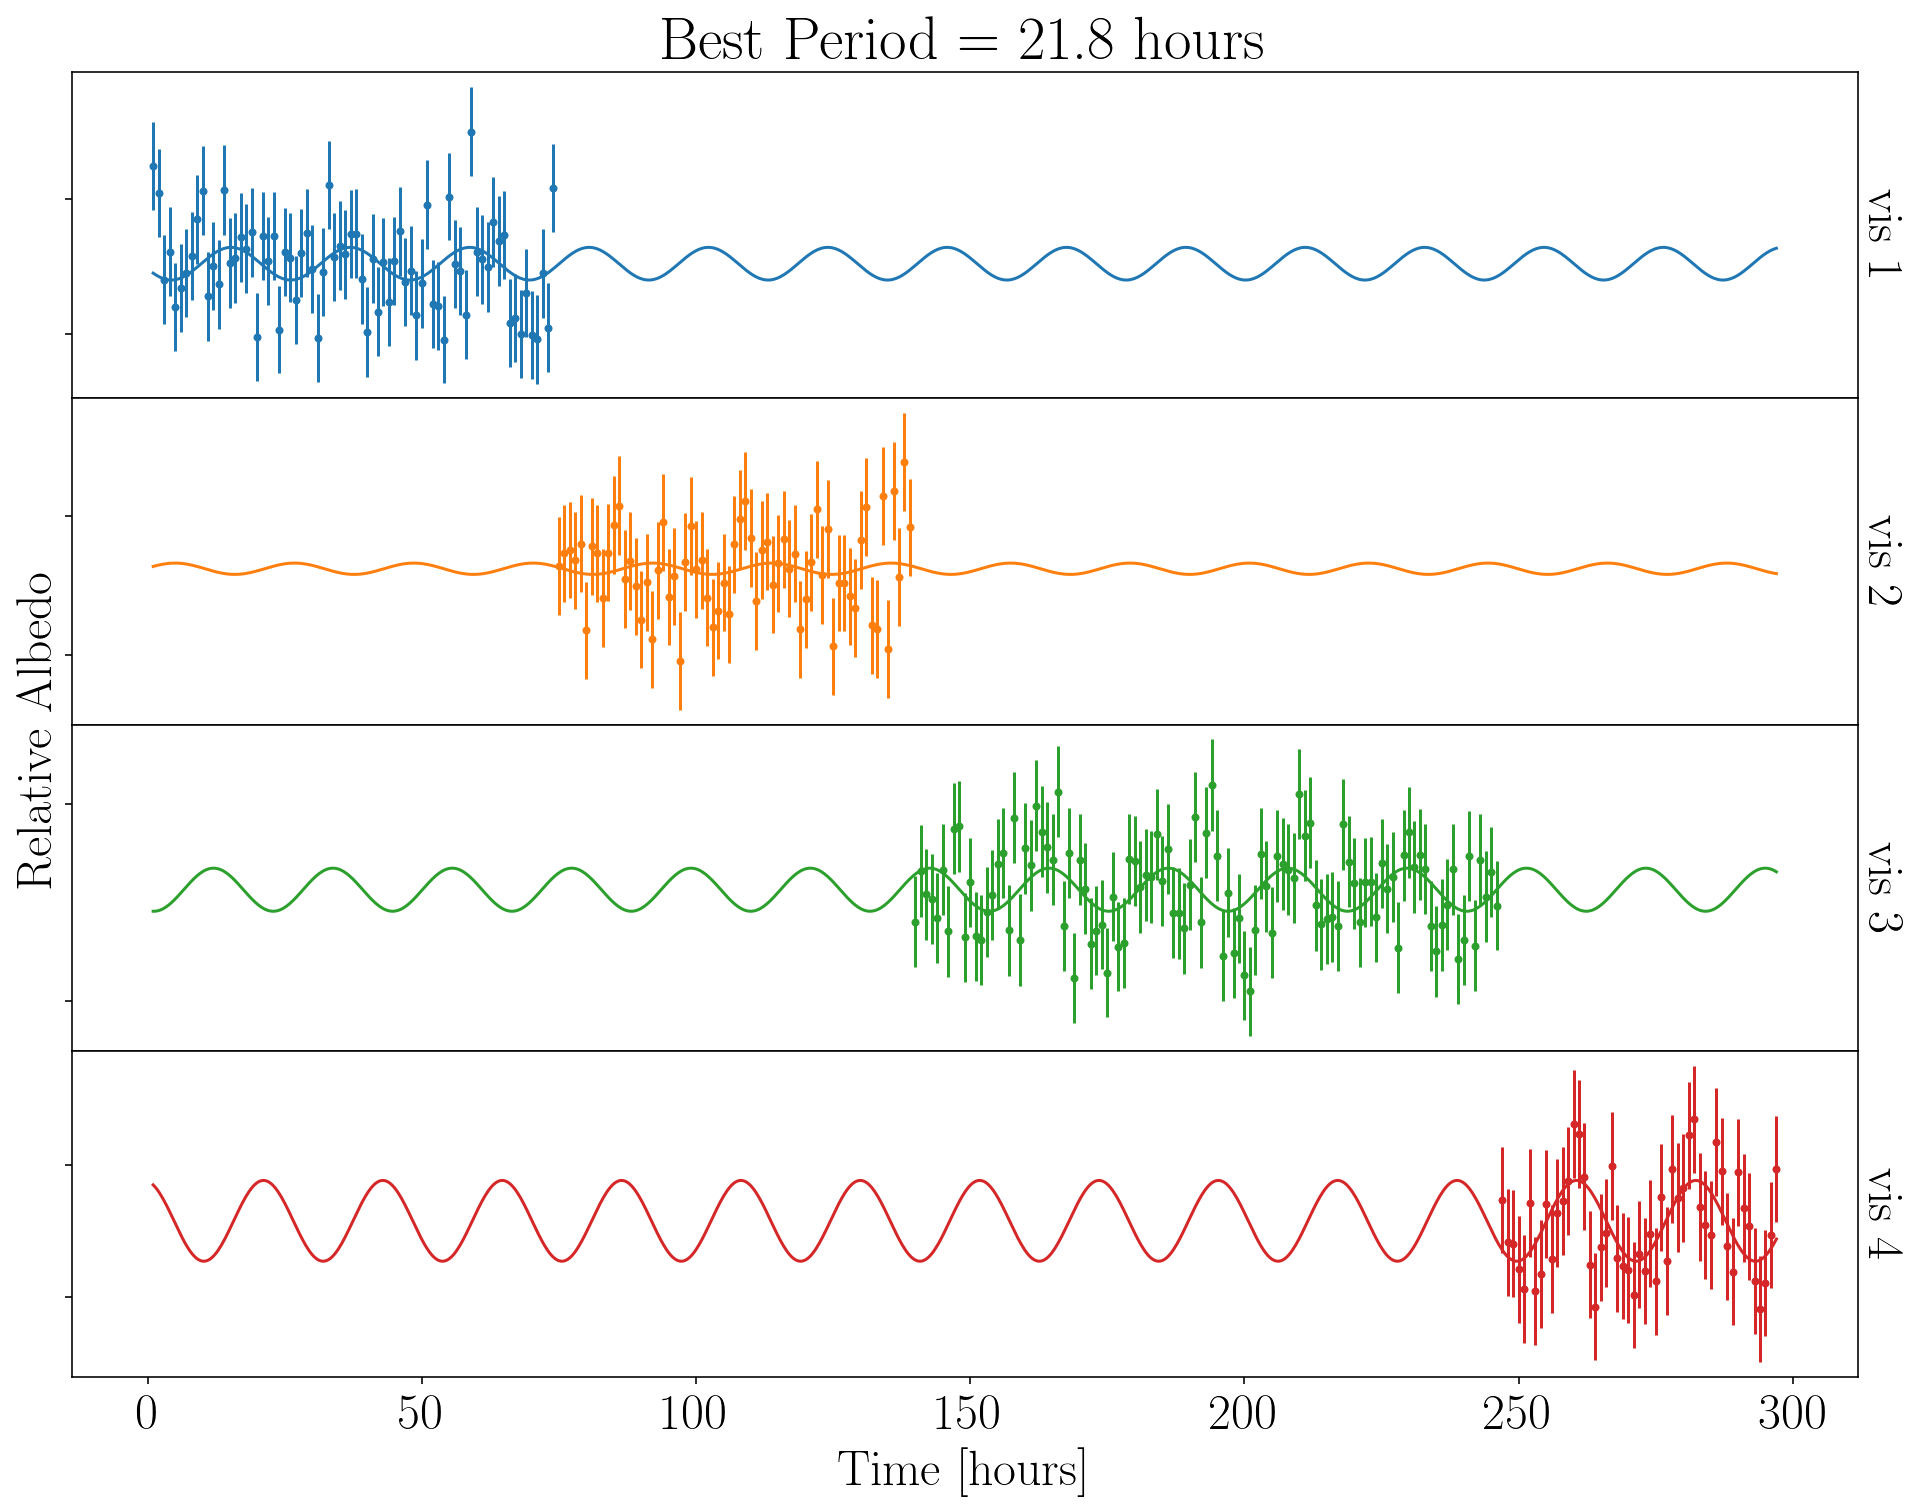

In [51]:
fig, ax = plt.subplots(len(bps), 1, figsize = (16,3*len(bps)), gridspec_kw={"hspace" : 0})
#ax.set_xlabel("Time [hours]")
#ax.set_ylabel("Albedo")

ax[0].set_title("Best Period = %.1f hours" %best_period)

tfit = np.linspace(np.min(t), np.max(t), 1000)

for i in range(len(bps)):

    yfit = lsmodel.predict(tfit, filts=bps[i][0])
    
    ax[i].errorbar(ts[i], ys[i], yerr=dys[i], fmt=".", color = "C%i" %(i%9))
    ax[i].plot(tfit, yfit, color = "C%i" %(i%9))
    ax[i].text(1.0, 0.5, bps[i][0], ha = "left", va = "center", transform=ax[i].transAxes, rotation = 270)
    ax[i].set_yticklabels([])

ax[i].set_xlabel("Time [hours]")
ylabel_spacing = 0.1
fig.text(ylabel_spacing, 0.5, "Relative Albedo", ha = "left", va = "center",
            fontsize=mpl.rcParams['font.size'], zorder=10, rotation = 90,
            bbox=dict(boxstyle="square", fc="none", ec="none"))

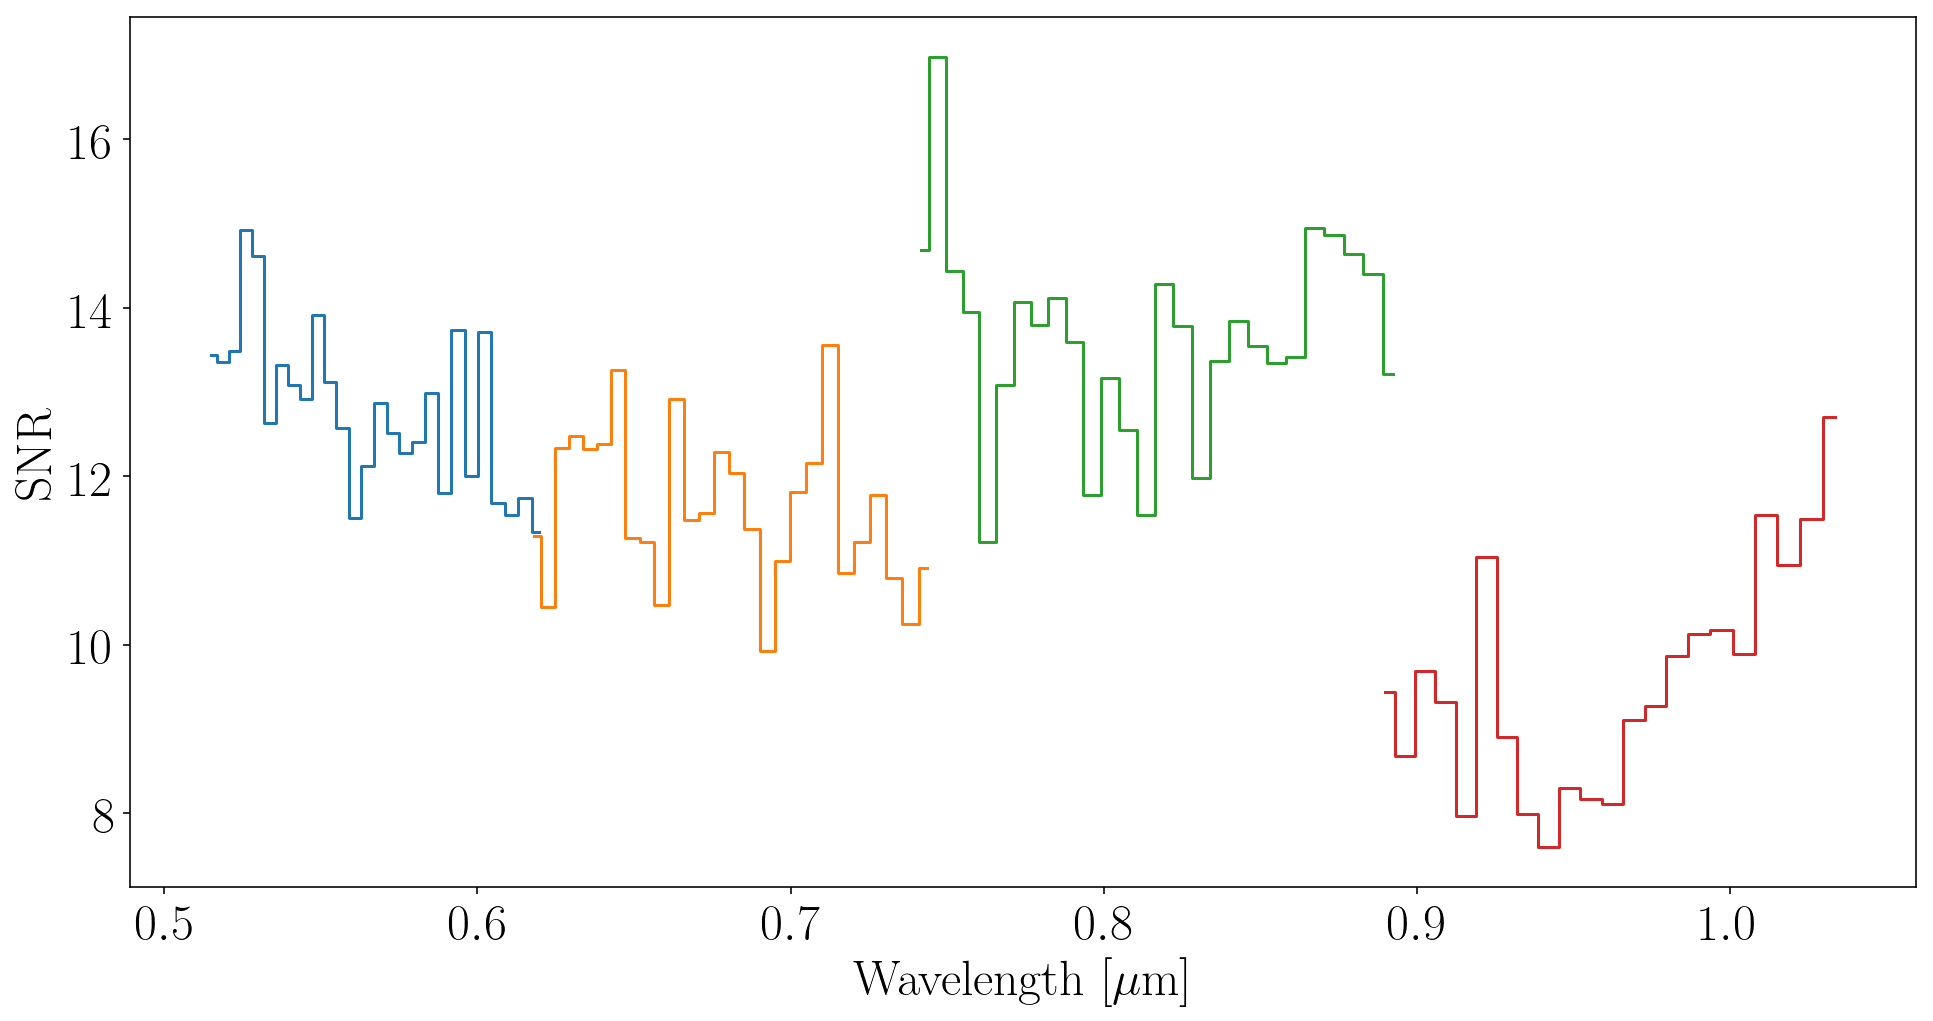

In [52]:
fig2, ax2 = plt.subplots(figsize = (16,8))
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel("SNR")

for i in range(len(bps)):
    ax2.plot(lams[i], Aobs[i]/Asigs[i], ls = "steps-mid")

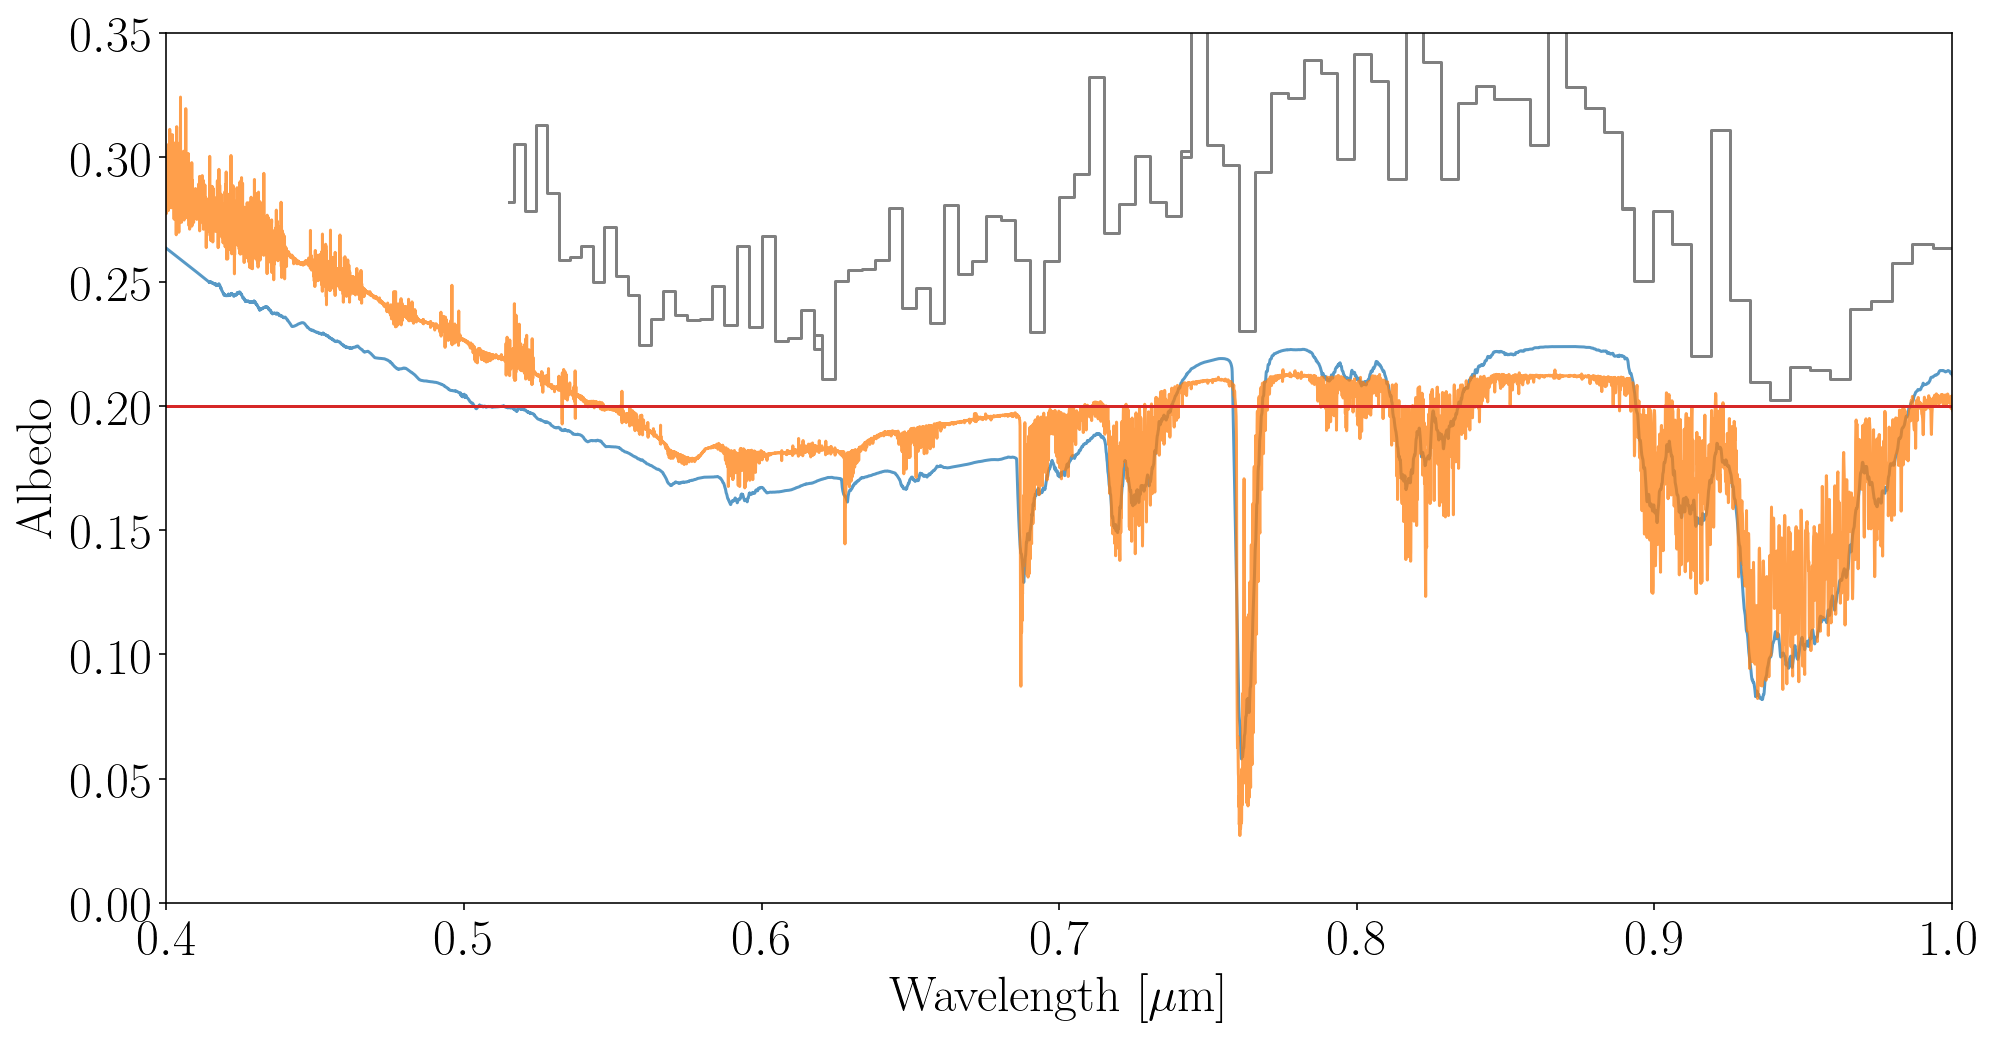

In [53]:
fig2, ax2 = plt.subplots(figsize = (16,8))
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel("Albedo")

ax2.set_xlim(0.4, 1.0)
ax2.set_ylim(0.0, 0.35)

ax2.plot(drmx.LAMHR, drmx.AHR, alpha=0.75, color = "C0")

ax2.plot(data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/wavelength"], 
         np.pi*data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"][10,:] / data.planet.Phi, 
         alpha = 0.75, color = "C1")

ax2.axhline(drmx.Ahr_flat, color = "C3")

for i in range(len(bps)):
    ax2.plot(lams[i], Aobs[i], ls = "steps-mid", color = "grey")

In [297]:
Ahr_flat  = drmx.Ahr_flat * np.ones(len(drmx.LAMHR))

# Run count rates (necessary to generate new wavelength grid)
drmx.cn.run_count_rates(Ahr_flat, drmx.LAMHR, drmx.cn.solhr)

In [310]:
data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"]

<HDF5 dataset "albedo": shape (120, 91999), type "<f4">

In [311]:
np.pi*data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"][0,:] / data.planet.Phi

array([3.3782821e+00, 3.4126220e+00, 3.3969946e+00, ..., 1.7698518e-06,
       1.7686009e-06, 1.7673541e-06], dtype=float32)

In [332]:
print(drmx.cn.planet)

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 12.4938
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 0.7576617601771974
- Phase angle (deg) : 90.00000250447816
- Lambertian phase function : 0.318309864328096
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0


In [331]:
print(data.planet)

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 12.4938
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 0.7576617601771974
- Phase angle (deg) : 90.00000250447816
- Lambertian phase function : 0.318309864328096
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0


In [289]:
print(drmx.cn.telescope)

Coronagraph: 
------------
- Telescope observing mode : IFS
- Minimum wavelength (um) : 0.2
- Maximum wavelength (um)  : 2.0
- Spectral resolution (lambda / delta-lambda)  : 140.0 
- Telescope/System temperature (K)  : 270.0 
- Detector temperature (K)  : 50.0 
- Telescope diameter (m)  : 15.0 
- Telescope emissivity  : 0.9 
- Inner Working Angle (lambda/D)  : 3.5 
- Outer Working Angle (lambda/D)  : 64.0 
- Telescope throughput  : 0.18 
- Raw Contrast  : 1e-10 
- Dark current (s**-1)  : 0.002 
- Horizontal pixel spread of IFS spectrum  : 3.0 
- Read noise per pixel  : 2.5 
- Maximum exposure time (hr)  : 1.0 
- Size of photometric aperture (lambda/D)  : 0.7 
- Quantum efficiency  : 0.675


In [367]:
np.pi / data.planet.Phi

9.869605078753121

# Piecing it together



In [1]:
def observe_earth_time_variability(drmx, Ntexp, istart, ibp, which_earth = "True_Earth", 
                                   which_phase = 90.):
    """
    Make a mock observation of Earth's spectrum as a function of time that is consistent 
    with the LUVOIR exoEarth DRM. 
    
    Parameters
    ----------
    drmx : HEC_DRM
        DRM object 
    Ntexp : int
        Number of consecutive hours to exposure
    istart : int
        Starting hour index
    ibp : int
        Bandpass Index
    which_earth : str
        Select from multiple VPL Earth Models:
            1. "True_Earth" 
            2. "Cloudless" 
            3. "Cirrus" 
            4. "Land_Switch"
    which_phase : int or float
        Select the planet phase:
            1. 45 (gibbous)
            2. 90 (quadrature)
            3. 135 (crescent)
            
    Returns
    -------
    spectrum : dict 
        "lam" : wavelength grid at native resolution 
        "obs" : observations at native resolution 
        "err" : errors at native resolution 
        "t0" : observation time stamps 
        "dt0" : observation time durations 
    lightcurve : 
        "time" : time grid for lightcurve 
        "obs" : observations at native temporal sampling
        "err" : errors at native temporal sampling
        "bp_names" : bandpass names for each observation
        "lam0" : wavelength for lightcurve 
        "dlam0" : wavelength width for lightcurve
    twod : 
        "time" : native temporal sampling
        "lam" : native wavelength grid
        "obs" : 2D observations at native temporal and spectral sampling
        "err" : 2D observational errors at native temporal and spectral sampling
    """

    # Setup specific telescope
    channel = spectroscopy.CHANNELS[drmx.bp_chan[ibp]]
    telescope = spectroscopy.default_luvoir(architecture=drmx.architecture, channel=channel)
    telescope.lammin = drmx.bandpasses[ibp][0]
    telescope.lammax = drmx.bandpasses[ibp][1]

    # Set number of consecutive exposures
    #N = 100
    N =  Ntexp

    # Set the integration time per exposure
    iN = 1

    # Set number of neighboring pixels to coadd (int or "all")
    iM = "all"

    # Instantiate DataGenerator object with EarthModel data
    data = DataGenerator(earth_model = EarthModel())

    # Select the Earth Model dataset with HDF5 file
    data.select_dataset(which_earth = which_earth, which_phase = which_phase)

    # Set default telescope, planet and star
    #data.set_default_observing_system()
    data.telescope = telescope
    data.planet = drmx.cn.planet
    data.star = drmx.cn.star
    
    # Calculate wavelength bin for spectral coadd
    lamlr = np.array([0.5*(telescope.lammin - telescope.lammin/telescope.resolution + telescope.lammax + telescope.lammax/telescope.resolution)])
    dlamlr = np.array([(telescope.lammax + telescope.lammax/telescope.resolution) - (telescope.lammin - telescope.lammin/telescope.resolution)])

    x, y, yerr = [], [], []
    t2, x2, y2, yerr2 = [], [], [], []

    # Loop over time increments (hours)
    for i in range(N):

        # Get snapshot of Earth data
        data.create_mock_dataset(istart = istart+i, N = 1, iN = 1, iM = 1, 
                                 imod = data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"].shape[0])

        # Parse data
        t0 = data.times + istart + i
        x0 = data.lam[0,:]
        y0 = data.obs[0,:]
        yerr0 = data.sig[0,:]
        
        # Save 2D dataset
        t2.append(t0)
        x2.append(x0)
        y2.append(y0)
        yerr2.append(yerr0)

        # Coadd spectral pixels into lightcurve
        specLR, errLR = cg.downbin_spec_err(y0, yerr0, x0, lamlr, dlam = dlamlr)

        # Save lightcurve quantities
        x.append(t0)
        y.append(specLR)
        yerr.append(errLR)
    
    # Final lightcurve quantities
    t = np.hstack(x)
    y = np.hstack(y)
    dy = np.hstack(yerr)
    bps = np.array([drmx.bp_names[ibp] for _ in range(N)])
    lightcurve = {"time" : t, 
                  "obs" : y, 
                  "err" : dy, 
                  "bp_names" : bps, 
                  "lam0" : lamlr, 
                  "dlam0" : dlamlr}
    
    # Final 2D dataset 
    t2, x2, y2, yerr2 = np.hstack(t2), np.array(x2), np.array(y2), np.array(yerr2)
    twod = {"time" : t2, 
            "lam" : x2, 
            "obs" : y2, 
            "err" : yerr2}
    
    # Create giant time window for giant coadd
    tlr = np.array([0.5*(t2[-1] + t2[0])])
    dtlr = np.array([(t2[-1] - t2[0])])

    # Loop over spectral elements
    tmpy = []
    tmpyerr = []
    for i in range(len(x2[0])):

        # Coadd in time for deep spectra
        specLR, errLR = cg.downbin_spec_err(y2[:,i], yerr2[:,i], t2, tlr, dlam = dtlr)
        tmpy.append(specLR)
        tmpyerr.append(errLR)

    # Final spectra quantites
    spectrum = {"lam" : x2[0], 
                "obs" : np.array(tmpy), 
                "err" : np.array(tmpyerr), 
                "t0" : tlr, 
                "dt0" : dtlr}
    
    return spectrum, lightcurve, twod

In [61]:
for ibp in range(len(drmx.bandpasses)):

    if np.isfinite(texpbp[ibp]):
        Ntexp = int(np.ceil(texpbp[ibp]))
    else:
        Ntexp = np.nan
        
    if (ibp not in case) and (np.isfinite(Ntexp)):
        
        

IndentationError: expected an indented block (<ipython-input-61-a3ade7e3649d>, line 10)

In [74]:
ibp = 8
istart = 0

if np.isfinite(texpbp[ibp]):
    Ntexp = int(np.ceil(texpbp[ibp]))
else:
    Ntexp = np.nan
    
spec, lc, twod = observe_earth_time_variability(drmx, Ntexp, istart, ibp)

HDF5 file opened


<ErrorbarContainer object of 3 artists>

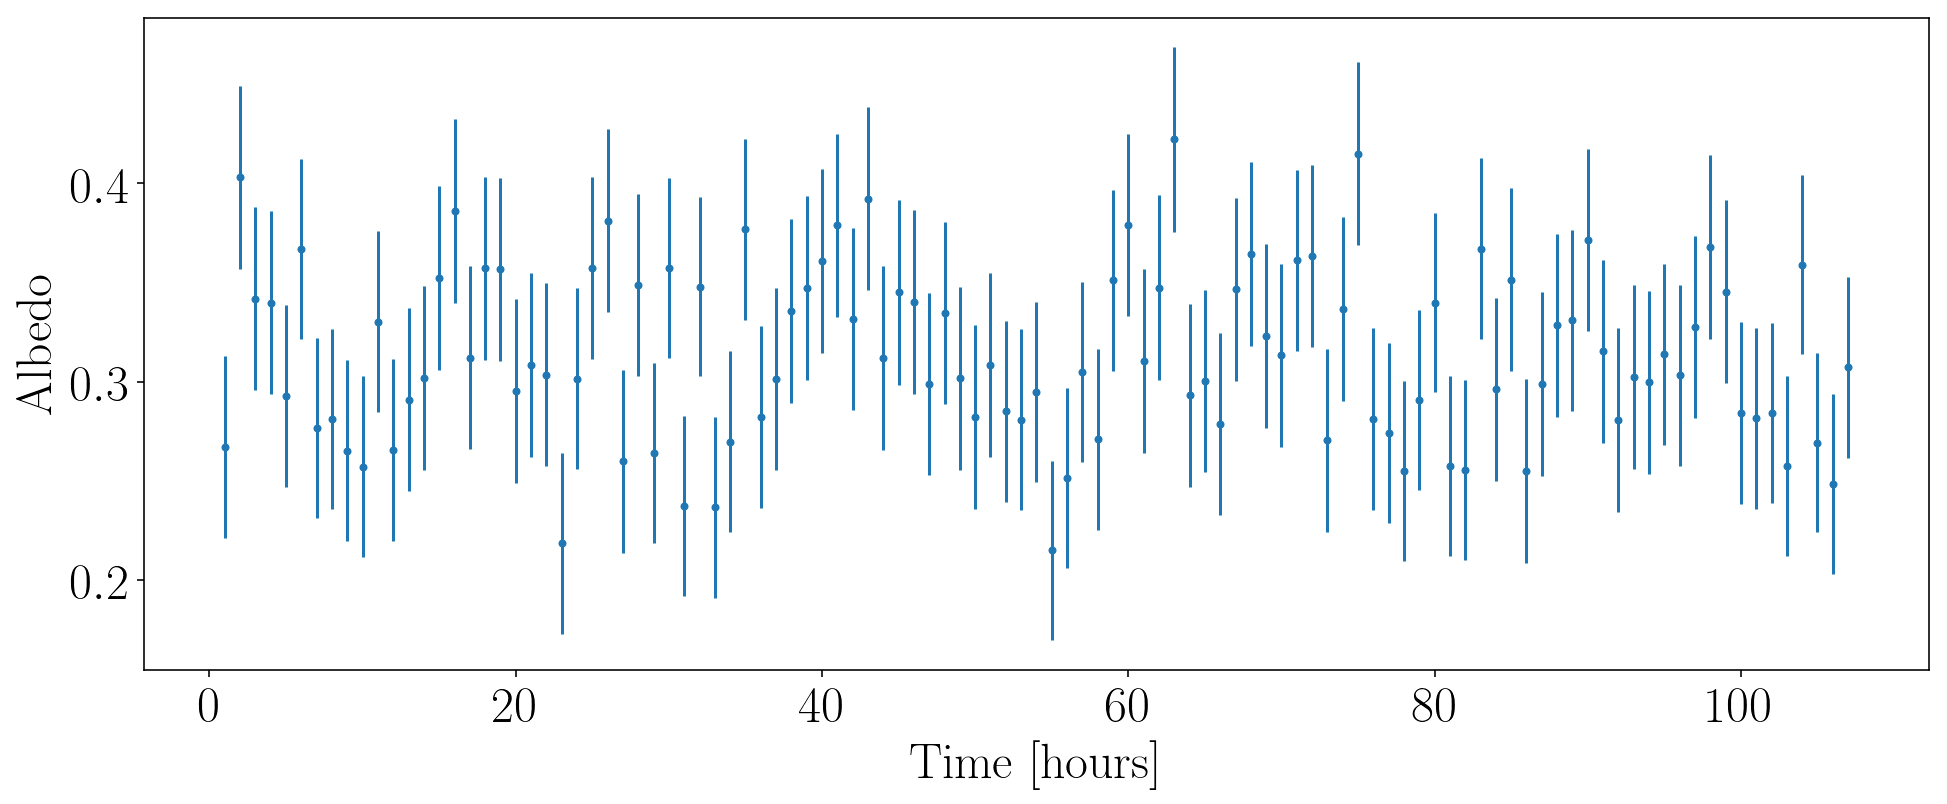

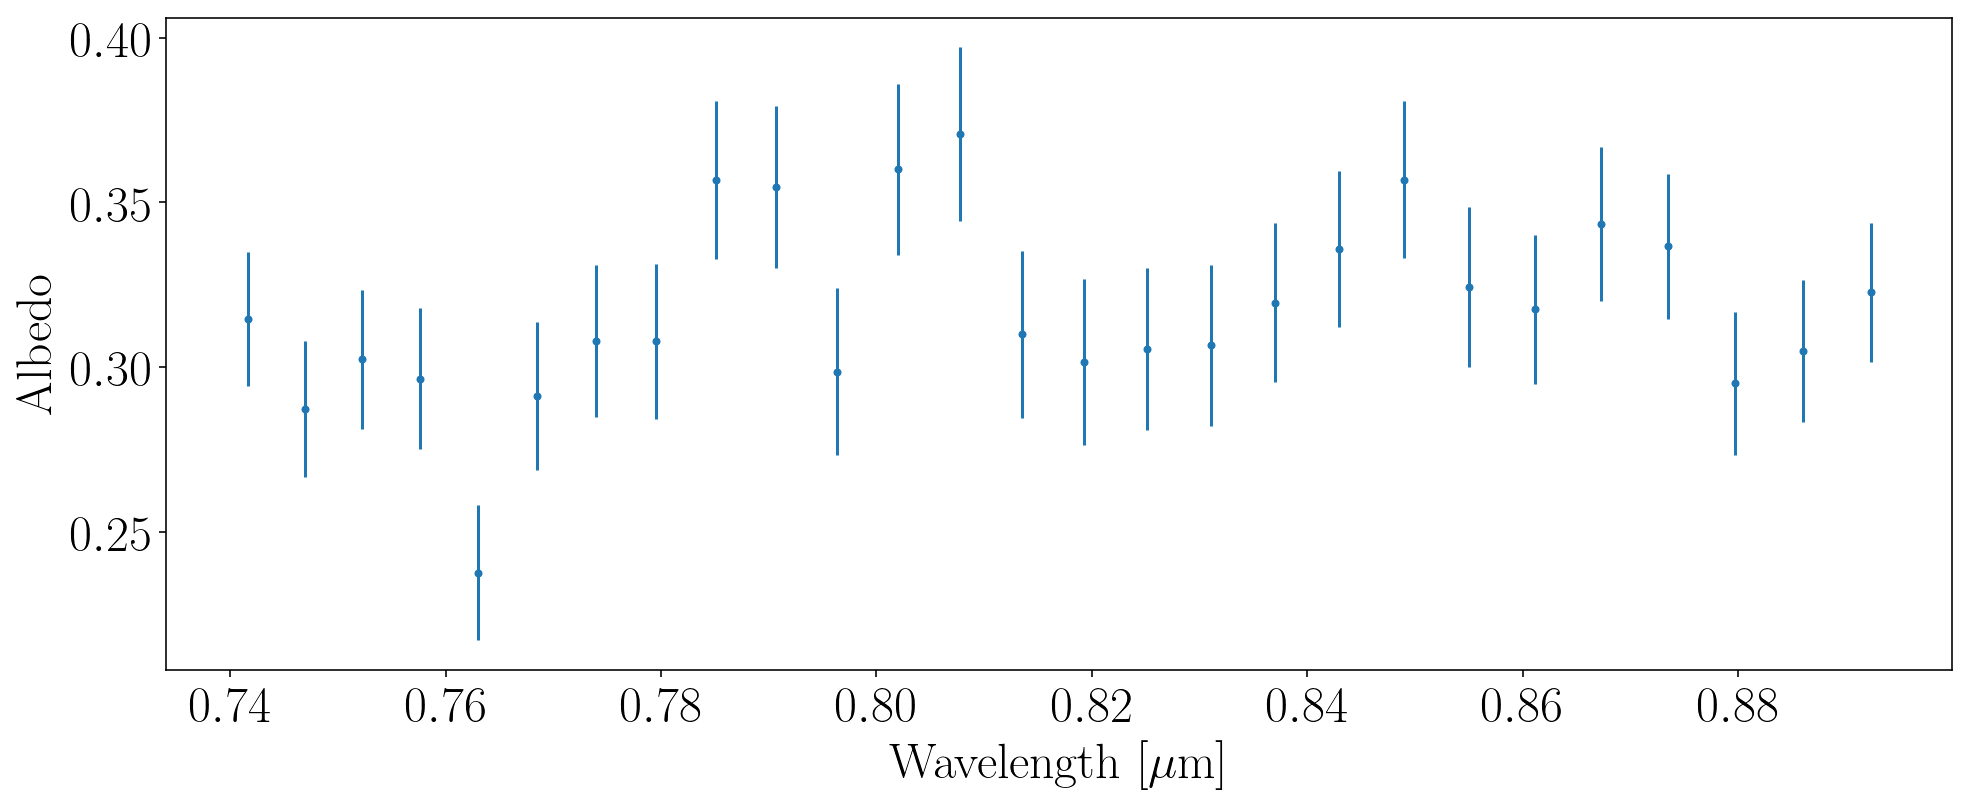

In [75]:
fig, ax = plt.subplots(figsize = (16,6))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Albedo")
ax.errorbar(lc["time"], lc["obs"], yerr=lc["err"], fmt = ".")

fig2, ax2 = plt.subplots(figsize = (16,6))
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel("Albedo")
ax2.errorbar(spec["lam"], spec["obs"], yerr=spec["err"], fmt = ".")